In [2]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as sl

In [48]:
# Setup Parameters
x_min = 0.
x_max = 100.
n_x = 1000
dt = 0.1

x_0 = x_min + (x_max - x_min) / 2
p_0 = 1.
sig = 0.01 * (x_max - x_min)

X = x_mesh = np.linspace(x_min, x_max, n_x)
dx = x_mesh[1] - x_mesh[0]
pi = np.pi

In [53]:
# Useful Functions
def normalization(wf: np.ndarray) -> np.ndarray:
    return wf / np.linalg.norm(wf)

def get_prob(wf: np.ndarray) -> np.ndarray:
    return np.abs(wf) ** 2

def overlap(f1: np.ndarray, f2: np.ndarray) -> float:
    return np.abs(np.dot(np.conj(f1), f2)) ** 2

class CrankNicolson:
    def __init__(self, dt=dt):
        dim = self.dim = len(X)
        diag = -2 * np.ones(dim)
        # diag[0] = diag[-1] = 1
        fac = - 0.5 * dt / dx ** 2
        upper = np.ones(dim)
        # upper[0] = upper[1] = 0
        lower = np.ones(dim)
        # lower[-1] = lower[-2] = 0
        self.Hdt = sp.dia_matrix(([diag, upper, lower], [0, 1, -1]), shape=(dim, dim), dtype=np.complex128) * fac
    
    def next(self, psi: np.ndarray) -> np.ndarray:
        dim = self.dim
        Hdt = self.Hdt
        b = (sp.eye(dim) - 1.j * Hdt / 2).dot(psi)
        A = (sp.eye(dim) + 1.j * Hdt / 2).tocsc()
        return sl.spsolve(A, b)
        # return normalization((sp.eye(dim) + 1j * Hdt).dot(psi))
    
    def __call__(self, x: np.ndarray) -> np.ndarray:
        return self.next(x)
    
class FFTSolv:
    # The choice of kmesh is matter!, large k is not exact!.
    def __init__(self, inter: int=1, cutoff: int=1, dt=dt):
        self.dx = dx
        self.dk = 2 * pi / ((x_max - x_min) * inter)
        self.p = inter
        self.kmesh = kmesh_ele = np.arange(len(X) * inter)
       
        for i in range(1, cutoff):
            self.kmesh = np.append(self.kmesh, kmesh_ele * i)
        self.kmesh = np.append(-self.kmesh[-1:0:-1], self.kmesh)
        self.kmesh = self.kmesh * self.dk
        self.indl = {(s, l): np.arange(l * len(X) + s, l * len(X) + len(X) * inter, inter) for l in range(-cutoff, cutoff) for s in range(inter)}
        
        self.dyna_phase = np.exp(-1.j * self.kmesh ** 2 * dt / 2)
    
    def cft(self, x: np.ndarray) -> np.ndarray:
        x_re = np.real(x)
        x_im = np.imag(x)
        res = np.zeros(len(self.kmesh), dtype=np.complex128)
        cache_fft = {}
        for s, l in self.indl:
            indl = self.indl[(s, l)]
            if s not in cache_fft:
                cache_fft[s] = np.fft.fft(np.exp(-1.j * 2 * pi * s * np.arange(len(X)) / (len(X) * self.p)) * x)
            res[indl] = cache_fft[s]
        res = np.exp(-1.j * self.kmesh * x_min) * res
        return res
    
    def cft_inv(self, x: np.ndarray) -> np.ndarray:
        x = np.exp(1.j * self.kmesh * x_min) * x
        cache_fft = {}
        res = np.zeros(len(X), dtype=np.complex128)
        for s, l in self.indl:
            indl = self.indl[(s, l)]
            if s not in cache_fft:
                cache_fft[s] = np.exp(1.j * 2 * pi * s * np.arange(len(X)) / (len(X) * self.p))
            res += cache_fft[s] * np.fft.ifft(x[indl])
        
        return res

    def next(self, psi: np.ndarray) -> np.ndarray:
        fac = self.dx * self.dk / (2 * pi)
        x = self.cft_inv(self.dyna_phase * self.cft(psi))
        return normalization(x)
    
    def __call__(self, x: np.ndarray) -> np.ndarray:
        return self.next(x)
    
class FFTSolvRough:
    def __init__(self, dt=dt):
        # self.dx = dx
        self.kmesh = np.fft.fftfreq(len(X)) / dx * 2 * pi
        self.dyna_phase = np.exp(-1.j * self.kmesh ** 2 * dt/2)
        self.k0 = min(self.kmesh)
        self.dim = len(X)
        
    def next(self, psi:np.ndarray) -> np.ndarray:
        psi_moment = np.fft.fft(psi * np.exp(- 1.j * self.k0 * dx * np.arange(self.dim)))
        return normalization(np.fft.ifft( psi_moment * self.dyna_phase * np.exp(-1.j * self.kmesh * x_min) ) ) * np.exp(1.j * self.k0 * X)
    
    def __call__(self, x:np.ndarray) -> np.ndarray:
        return self.next(x)

Crank_Nicolson: 0.9999999999999996	FFT: 0.9999999999999996	Overlap: 0.9999999999999998
Crank_Nicolson: 0.9999999999999959	FFT: 1.0	Overlap: 0.1384056941044858
Crank_Nicolson: 0.999999999999992	FFT: 1.0	Overlap: 0.0003648303747058874
Crank_Nicolson: 0.9999999999999883	FFT: 1.0	Overlap: 1.7997592551315163e-08
Crank_Nicolson: 0.9999999999999848	FFT: 1.0	Overlap: 1.613635891371352e-14
Crank_Nicolson: 0.9999999999999803	FFT: 1.0	Overlap: 2.52314401800469e-22
Crank_Nicolson: 0.999999999999977	FFT: 0.9999999999999999	Overlap: 1.937111314889085e-30
Crank_Nicolson: 0.9999999999999735	FFT: 0.9999999999999996	Overlap: 1.9930143674620476e-30
Crank_Nicolson: 0.9999999999999697	FFT: 0.9999999999999996	Overlap: 3.5572039195842376e-30
Crank_Nicolson: 0.9999999999999653	FFT: 0.9999999999999997	Overlap: 7.262516587617241e-30


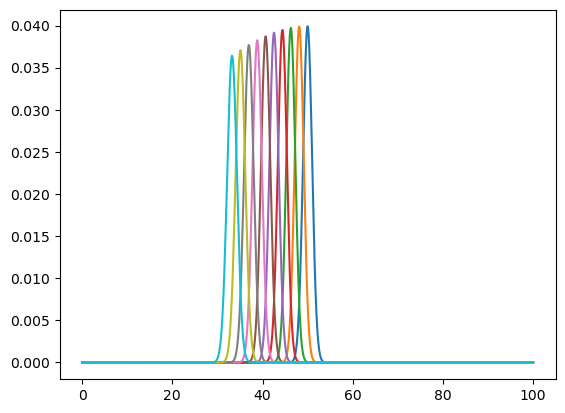

In [54]:
# Initialization

p_0 = 50

ini_psi = normalization(np.exp( - (X - x_0) ** 2 / (4 * sig ** 2) - 1.j * (X - x_0) * p_0))
ini_psi_op = normalization(np.exp( - (X - x_0) ** 2 / (4 * sig ** 2) + 1.j * (X - x_0) * p_0))

# Dynamics

import matplotlib.pyplot as plt


cn_nn = 50
ft_nn = 1
cn_solver = CrankNicolson(dt / cn_nn)
# ft_solver = FFTSolv(inter=1, cutoff=1, dt=dt / ft_nn)
ft_solver = FFTSolvRough(dt / ft_nn)
psi1 = ini_psi
psi2 = ini_psi
for i in range(10):
    p1 = get_prob(psi1)
    p2 = get_prob(psi2)
    plt.plot(X, p2)

    print(f"Crank_Nicolson: {sum(p1)}\tFFT: {sum(p2)}\tOverlap: {overlap(psi1, psi2)}")
    # print(f"<X>: {sum(p1 * X), sum(p2 * X)}\t<v>: {sum((p1-p2) * X) / (i+1)}")
    
    for _ in range(cn_nn):
        psi1 = cn_solver(psi1)
        
    for _ in range(ft_nn):
        psi2 = ft_solver(psi2)
    
    
    psi1[0] = psi1[-1] = 0
    psi2[0] = psi2[-1] = 0
    psi2 = normalization(psi2)
    
plt.show()
    

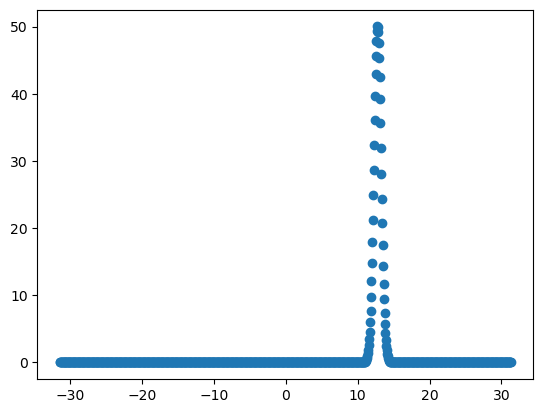

In [35]:
plt.scatter(np.fft.fftfreq(len(X)) / dx * 2 * pi, get_prob(np.fft.fft(ini_psi)))
plt.show()

In [7]:
ft_solver = FFTSolv(inter=50, cutoff=5)
print(ft_solver.dk)

0.012566370614359173


In [38]:
min(np.fft.fftfreq(len(X)) / dx * 2 * pi)

-31.384510609362035

In [39]:
-np.pi / dx

-31.38451060936203

In [33]:
np.sum(ini_psi * np.conj(ini_psi))

(1+0j)